In [1]:
import numpy as np 

import firtez_dz as frz
import matplotlib.pyplot as plt 

In [2]:
atm = frz.read_model("/home/milic/data/SCIP_CaII_JMB/out_guess_step_3.bin")

In [3]:
atm.tem.shape

(601, 215, 64)

In [4]:
atm.tau.shape

(601, 215, 64)

In [5]:
atm.vmic[0,0]

array([6.33093837e+09, 6.33093837e+09, 6.33093837e+09, 6.33093837e+09,
       6.33093837e+09, 6.33093837e+09, 6.33093837e+09, 6.33093837e+09,
       6.33093837e+09, 6.33093837e+09, 6.33093837e+09, 6.33093837e+09,
       6.33093837e+09, 6.33093837e+09, 6.33093837e+09, 6.33093837e+09,
       6.39833907e+09, 6.66794189e+09, 6.93754419e+09, 7.20714701e+09,
       7.47675034e+09, 7.74635315e+09, 8.01595597e+09, 8.28555930e+09,
       8.55516160e+09, 8.82476544e+09, 9.09436723e+09, 9.36397005e+09,
       9.63357389e+09, 9.90317568e+09, 1.01727795e+10, 1.04423823e+10,
       1.07119841e+10, 1.09815880e+10, 1.12511898e+10, 1.15207936e+10,
       1.17903964e+10, 1.20600003e+10, 1.23296031e+10, 1.25992049e+10,
       1.28688077e+10, 1.31384105e+10, 1.34080143e+10, 1.36776161e+10,
       1.39472200e+10, 1.42168228e+10, 1.44864246e+10, 1.47560284e+10,
       1.48234291e+10, 1.48234291e+10, 1.48234291e+10, 1.48234291e+10,
       1.48234291e+10, 1.48234291e+10, 1.48234291e+10, 1.48234291e+10,
      

In [6]:
# Let's interpolate stuff

In [7]:
tau_new = np.linspace(-5,0,51)
NZ_new = len(tau_new)

In [8]:
NX,NY,NZ = atm.tau.shape

In [9]:
# We need T, p, vz, Btot, inc, vturb
atm_new = np.zeros([6, NX, NY, NZ_new])

In [10]:
btot = np.sqrt(atm.bz**2.0 + atm.bx**2.0 + atm.by**2.0)
inc = np.arccos(atm.bz / (btot + 1.0))

In [11]:
from tqdm import tqdm

In [14]:
for i in tqdm(range(0,NX)):
    for j in range(0,NY):
        atm_new[0,i,j,:] = np.interp(tau_new, atm.tau[i,j,::-1], atm.tem[i,j,::-1])
        atm_new[1,i,j,:] = np.interp(tau_new, atm.tau[i,j,::-1], atm.vz[i,j,::-1])
        atm_new[2,i,j,:] = np.interp(tau_new, atm.tau[i,j,::-1], np.sqrt(atm.vmic[i,j,::-1]))
        atm_new[3,i,j,:] = np.interp(tau_new, atm.tau[i,j,::-1], btot[i,j,::-1])
        atm_new[4,i,j,:] = np.interp(tau_new, atm.tau[i,j,::-1], inc[i,j,::-1])
        atm_new[5,i,j,:] = np.interp(tau_new, atm.tau[i,j,::-1], atm.pg[i,j,::-1])
    #print (i)
        

100%|████████████████████████████████████████| 601/601 [00:01<00:00, 375.09it/s]


In [15]:
atm_new.shape

(6, 601, 215, 51)

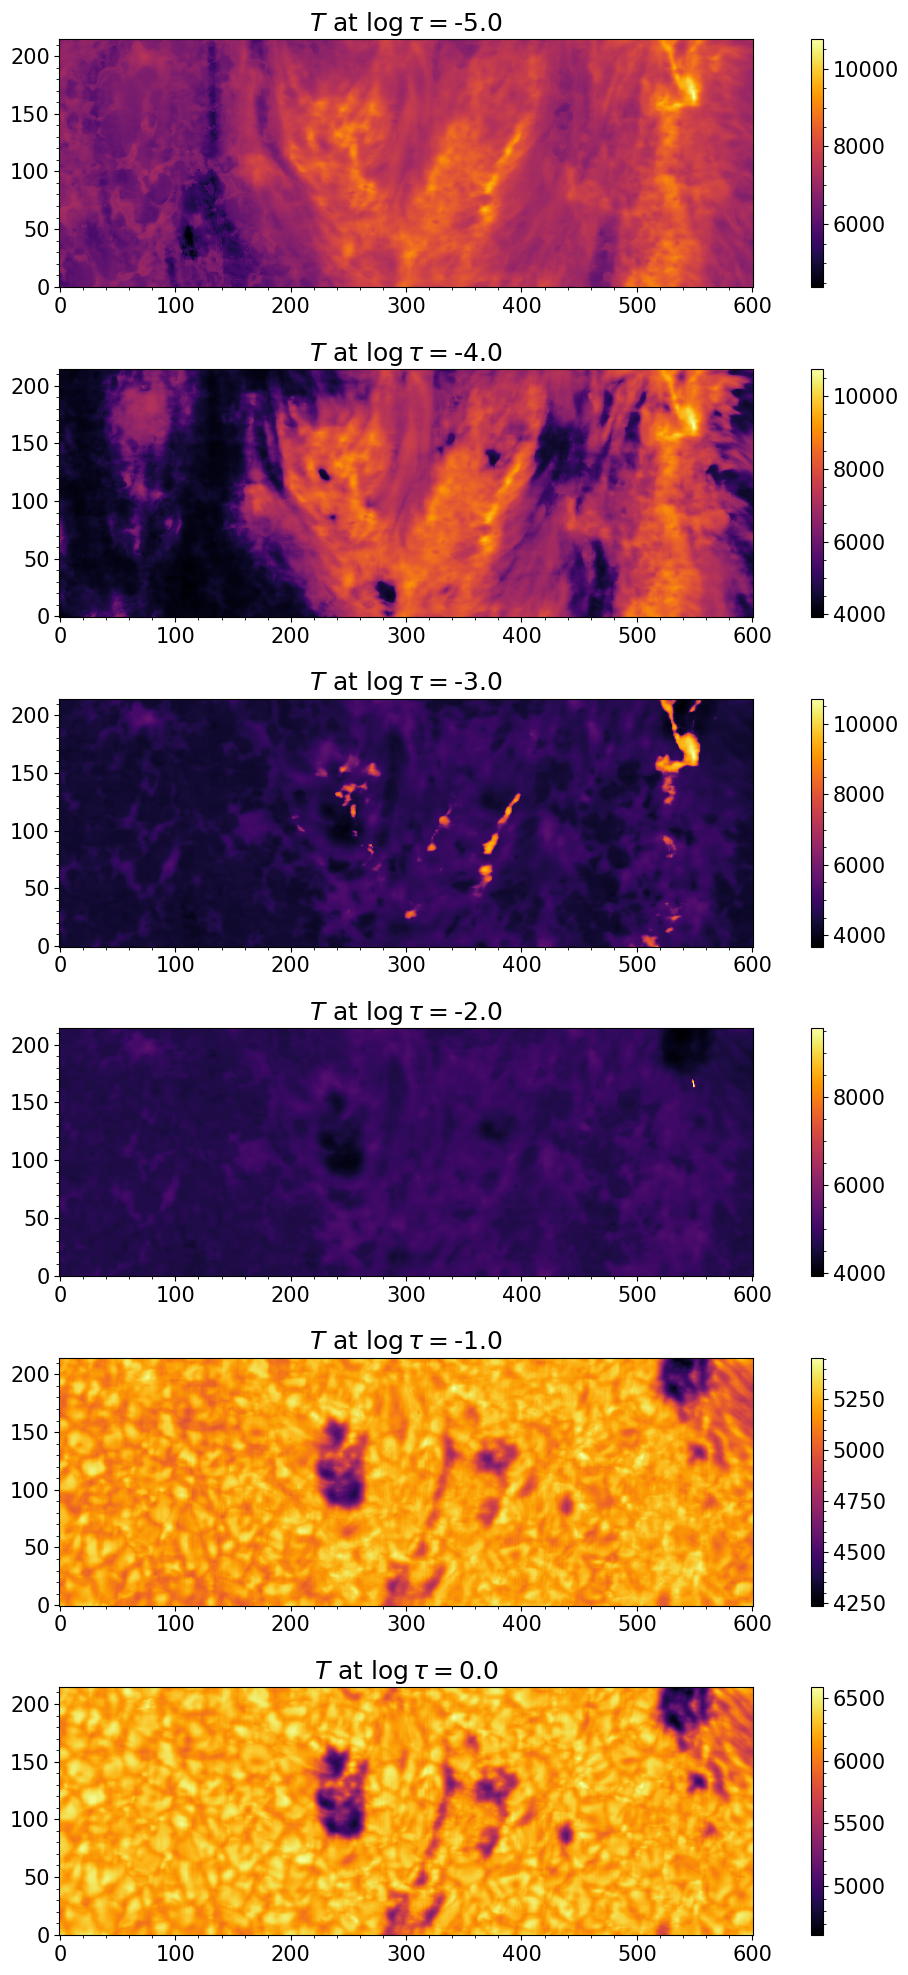

In [16]:
plt.figure(figsize=[12,20])
for d  in range(0,51,10):
    plt.subplot(6,1,d//10+1)
    plt.imshow(atm_new[0,:,:,d].T, cmap = 'inferno', origin='lower')
    plt.colorbar()
    plt.title("$T$ at $\log\\tau = $" + str(tau_new[d]))
plt.savefig("T_plts.png", bbox_inches='tight')
plt.tight_layout()

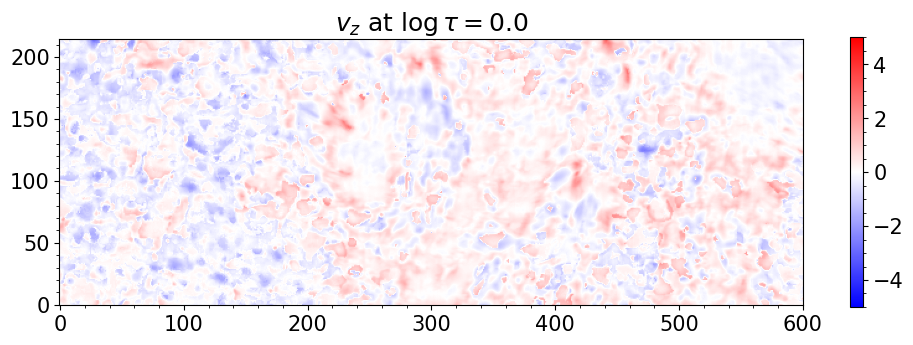

In [17]:
d = -1
plt.figure(figsize=[12,3.5])
plt.imshow(atm_new[1,:,:,d].T/1E5 + 0.47, cmap = 'bwr', origin='lower', vmin=-5,vmax=5)
plt.colorbar()
plt.title("$v_z$ at $\log\\tau = $" + str(tau_new[d]))
plt.savefig("vz_photo.png", bbox_inches='tight')

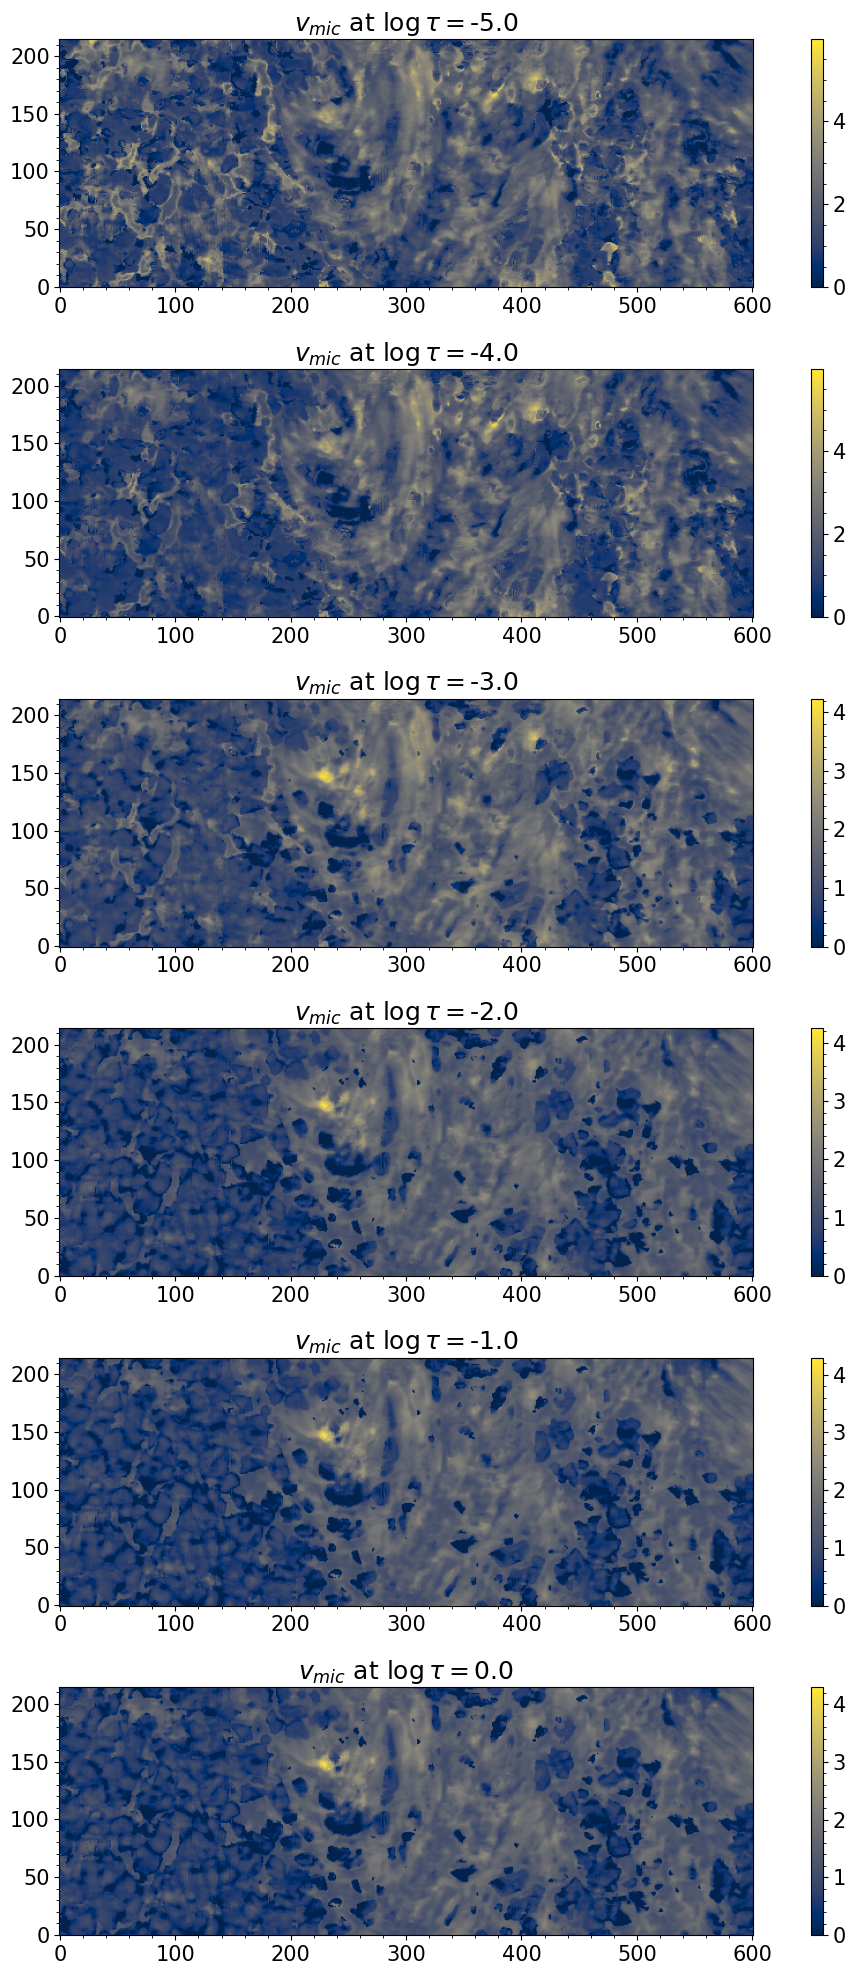

In [18]:
plt.figure(figsize=[12,20])
for d  in range(0,51,10):
    plt.subplot(6,1,d//10+1)
    plt.imshow(atm_new[2,:,:,d].T/1E5, cmap = 'cividis', origin='lower')
    plt.colorbar()
    plt.title("$v_{mic}$ at $\log\\tau = $" + str(tau_new[d]))
plt.savefig("vmic_plts.png", bbox_inches='tight')
plt.tight_layout()

In [19]:
vzmean = np.mean(atm_new[1,:100,:100,-11])
print (vzmean/1E5)

-0.47750112527365296


In [16]:
# To cluster, we are gonna normalize these vectors somehow. 

In [20]:
atm_new_vector = np.copy(atm_new)

In [21]:
for p in range(0,5):
    atm_new_vector[p] = (atm_new[p] - np.amin(atm_new[p])) / (np.amax(atm_new[p]) - np.amin(atm_new[p]))

In [22]:
from sklearn.cluster import KMeans

In [23]:
atm_new_vector = atm_new_vector[:,:,:,::10]

In [24]:
atm_new_vector.shape

(6, 601, 215, 6)

In [25]:
atm_new_vector = atm_new_vector.transpose(1,2,0,3)

In [27]:
atm_new_vector = atm_new_vector.reshape(601*215, 6*6)

In [28]:
atm_new_vector.shape

(129215, 36)

In [29]:
to_cluster = np.copy(atm_new_vector)
to_cluster[:,0:4] *= 2
to_cluster[:,4:6] *= 20
to_cluster[:,11] *= 20


In [30]:
nc = 20
k_means = KMeans(init="k-means++",n_clusters=20)
k_means.fit(to_cluster[:,:6])

KMeans(n_clusters=20)

In [31]:
k_means.labels_.shape

(129215,)

In [32]:
labelihnos = k_means.labels_.reshape(601,215)

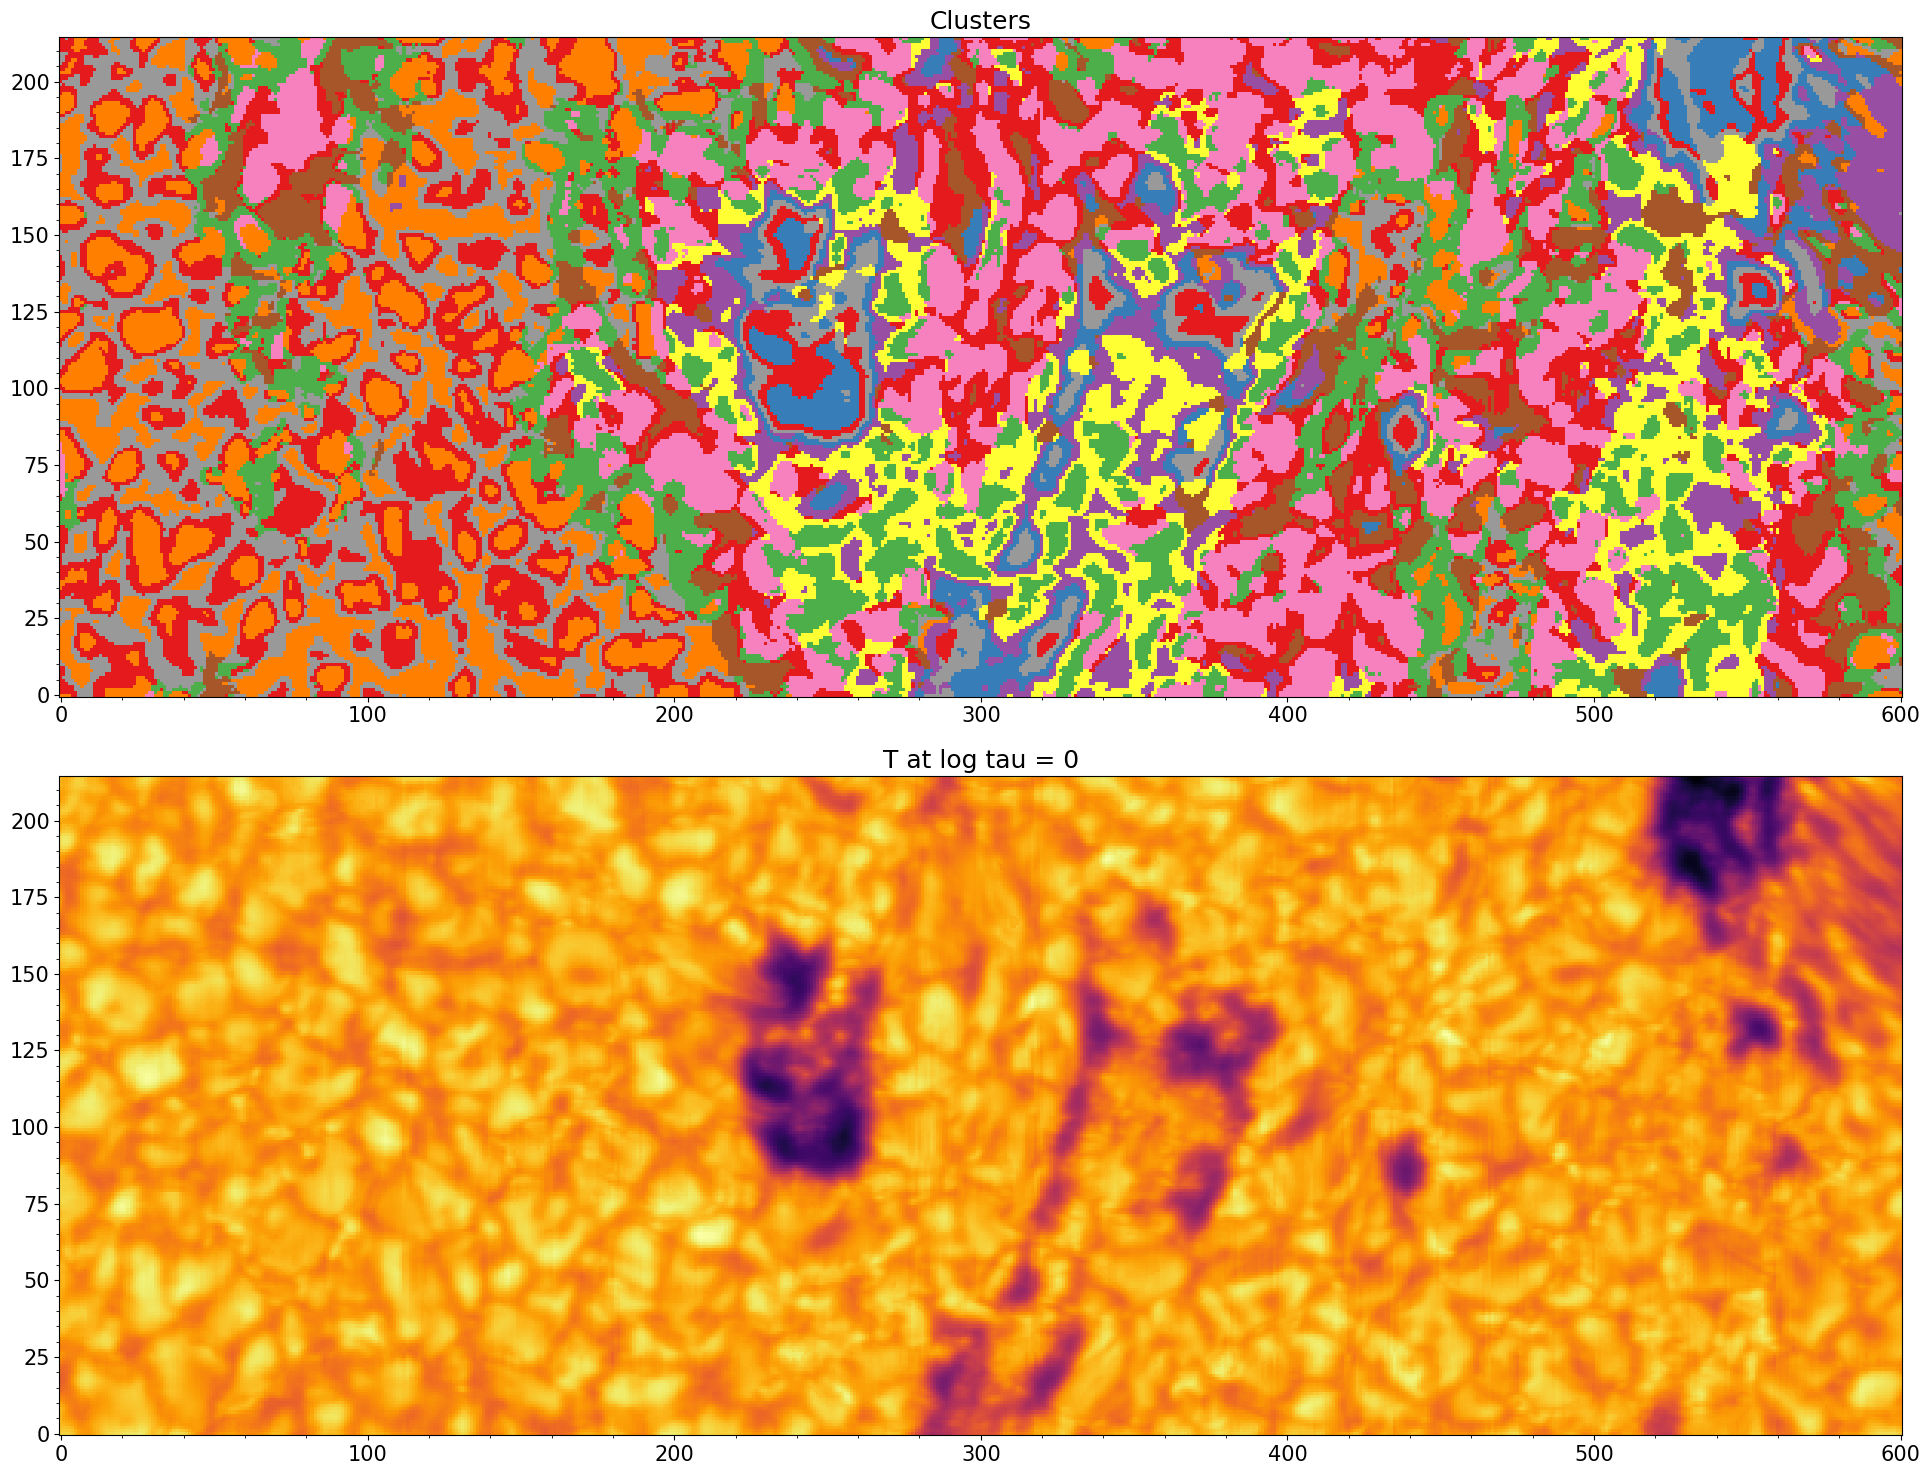

In [33]:
plt.figure(0,(25,15))
plt.subplot(2,1,1)
plt.imshow(labelihnos.T, origin='lower', cmap='Set1')
# plt.imshow(atm_new[0,:,:,-5].T, cmap = 'inferno', origin='lower', alpha=0.5)
plt.title("Clusters")
plt.subplot(2,1,2)
plt.imshow(atm_new[0,:,:,-5].T, cmap = 'inferno', origin='lower')
plt.title("T at log tau = 0")
plt.tight_layout()
# plt.colorbar()
plt.savefig("clusters.png",bbox_inches='tight')

In [57]:
# Save labels so we have them for later:
kek = fits.PrimaryHDU(labelihnos)
kek.writeto("scip_20_clusters_labels.fits",overwrite=True)

In [64]:
## Create some mean, snapi format atmospheres from these labels and the original firtez atmospher

refine = 1
NZ_new = len(atm.z[0,0])
if (refine):
    NZ_new *=2

mean_atms = np.zeros([12,nc,1,NZ_new])
mean_atms[0,:,:,:] = np.linspace(0.3,-6.0,NZ_new)[None,None,:]


z_new = np.linspace(atm.z[0,0,0], atm.z[0,0,-1],NZ_new)
z_old = np.copy(atm.z[0,0])
mean_atms[1,:,:,:] = z_new[None,None,:] * 1E5

for l in range(0,nc):

    choice = np.where(labelihnos == l)
    # we are only going to average T and p, the rest can be zero!
    to_average = atm.tem[choice][:]
    temp = np.mean(to_average,axis=0)
    mean_atms[2,l,0,:] = np.interp(z_new, z_old, temp)
    
    to_average = np.log10(atm.pg[choice][:])
    temp = np.mean(to_average,axis=0)
    mean_atms[3,l,0,:] = np.interp(z_new, z_old, temp)
    
    to_average = np.sqrt(atm.vmic[choice][:])
    temp = np.mean(to_average,axis=0)
    mean_atms[8,l,0,:] = np.interp(z_new, z_old, temp)
    

mean_atms[3,:,:,:] = 10.0 ** mean_atms[3,:,:,:]
mean_atms[4,:,:,:] = 0.01 * mean_atms[3,:,:,:]
    

In [65]:
mean_atms.shape

(12, 20, 1, 128)

In [66]:
falc = np.loadtxt("falc.dat",unpack=True, skiprows=1)
falc.shape

(12, 57)

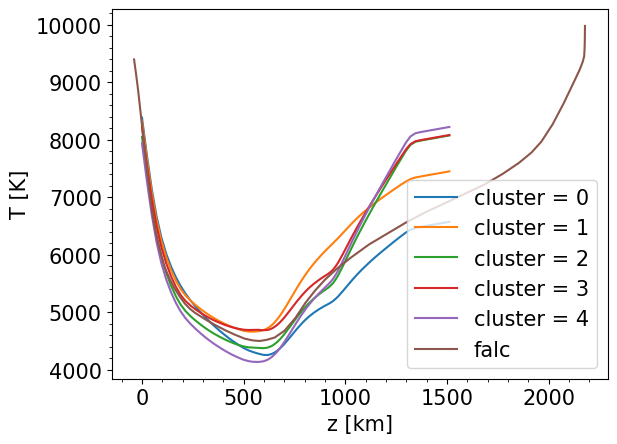

In [68]:
for l in range(0,5):
    plt.plot(z_new, mean_atms[2,l,0,:], label = 'cluster = '+str(l))
    plt.xlabel("z [km]")
    plt.ylabel("T [K]")
plt.plot(falc[1,:]/1E5+60, falc[2,:], label='falc')
plt.legend()
plt.savefig("mean_T.png")


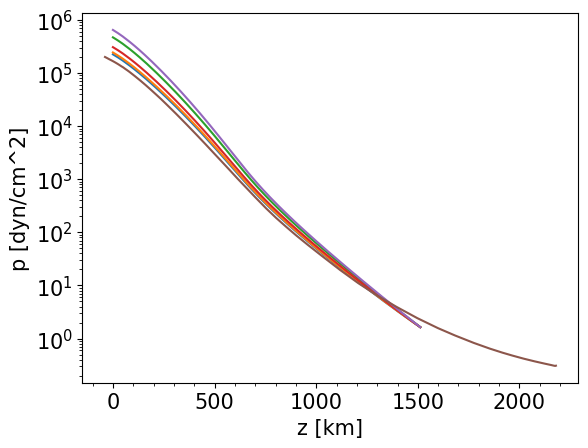

In [69]:
for l in range(0,5):
    plt.semilogy(mean_atms[1,l,0,:]/1E5, mean_atms[3,l,0,:])
    plt.xlabel("z [km]")
    plt.ylabel("p [dyn/cm^2]")
plt.semilogy(falc[1,:]/1E5+60, falc[3,:])
plt.savefig("mean_p.png")


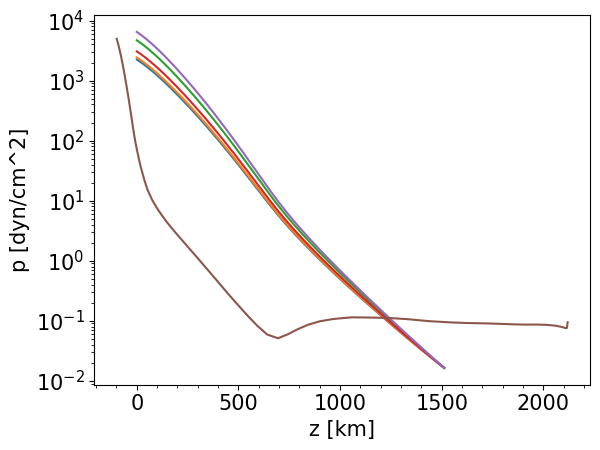

In [70]:
for l in range(0,5):
    plt.semilogy(mean_atms[1,l,0,:]/1E5, mean_atms[4,l,0,:])
    plt.xlabel("z [km]")
    plt.ylabel("p [dyn/cm^2]")
plt.semilogy(falc[1,:]/1E5, falc[4,:])
plt.savefig("mean_T.png")

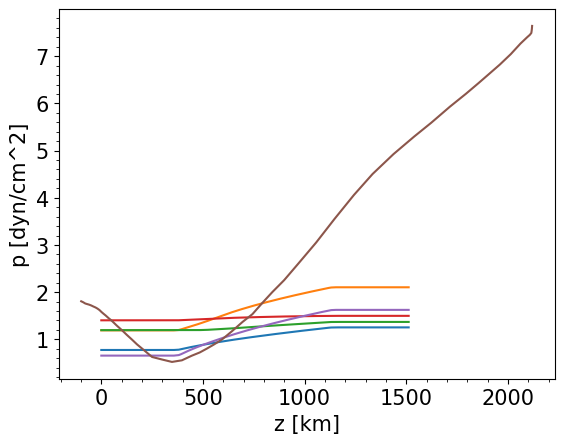

In [71]:
for l in range(0,5):
    plt.plot(mean_atms[1,l,0,:]/1E5, mean_atms[8,l,0,:]/1E5)
    plt.xlabel("z [km]")
    plt.ylabel("p [dyn/cm^2]")
plt.plot(falc[1,:]/1E5, falc[8,:]/1E5)
plt.savefig("mean_vmic.png")

In [72]:
# technical stuff not to break the synth code
mean_atms[-2,:,:,:] = 0.5
mean_atms[-1,:,:,:] = 0.5

In [73]:
from astropy.io import fits
kek = fits.PrimaryHDU(mean_atms[:,:,:,::-1])
kek.writeto("scip_20_clusters.fits",overwrite=True)

In [74]:
mean_atms = mean_atms.astype('double')

In [75]:
import pyana
pyana.fzwrite("scip_20_clusters.f0",mean_atms[:,:,:,::-1],0,'bla')

1

In [115]:

# ------------ run the syntesis --------------


In [76]:
spectra = pyana.fzread("/home/milic/data/SCIP_CaII_JMB/snapi_modeling/scip_20_clusters_8542.f0")["data"]

In [77]:
spec_falc = np.loadtxt("/home/milic/data/SCIP_CaII_JMB/snapi_modeling/falc_8542.dat",unpack=True)

In [78]:
spec_falc.shape

(5, 601)

In [79]:
spectra.shape

(20, 1, 4, 601)

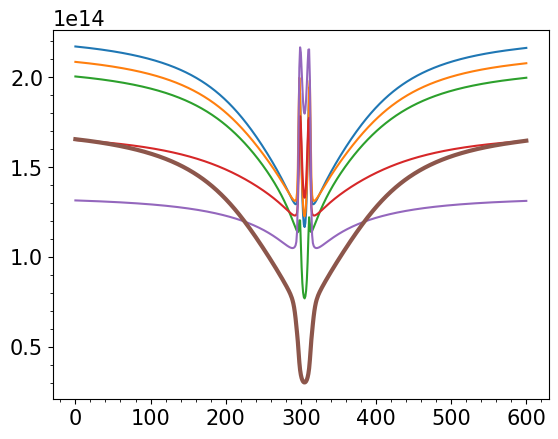

In [85]:
for l in range(15,20):
    plt.plot(spectra[l,0,0,:]+0.5E14,label=str(l))
plt.plot(spec_falc[1],linewidth=3,label='falc')
#plt.legend()
plt.savefig("ca_8542.png", bbox_inches='tight')
